In [1]:
import os
os.chdir("../")

In [63]:
import json
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv
from sklearn import metrics
plt.rc('font', family="Arial")

import torch
import torch.nn.functional as F

from groundingdino.util.inference import load_model, load_image, predict, annotate
import groundingdino.datasets.transforms as T

from xplique.plots import plot_attributions

from torchvision.ops import box_convert
from utils import COCO_TEXT_PROMPT, coco_classes, coco_classes_grounding_idx, mkdir

2024-10-12 16:03:04.187969: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-12 16:03:04.225291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 16:03:04.225328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 16:03:04.226397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 16:03:04.232615: I tensorflow/core/platform/cpu_feature_guar

In [3]:
data_transform = T.Compose(
    [
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [54]:
eps = torch.finfo(torch.float32).eps

In [4]:
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    image = Image.fromarray(image)
    image_transformed, _ = data_transform(image, None)
    return image_transformed

In [5]:
# input
image_path = "datasets/coco/val2017/000000090003.jpg"
image = cv2.imread(image_path)
target_box = [219,213,493,365]
target_class = [38]
TEXT_PROMPT = "person . bicycle . car . motorcycle . airplane . bus . train . truck . boat . traffic light . fire hydrant . stop sign . parking meter . bench . bird . cat . dog . horse . sheep . cow . elephant . bear . zebra . giraffe . backpack . umbrella . handbag . tie . suitcase . frisbee . skis . snowboard . sports ball . kite . baseball bat . baseball glove . skateboard . surfboard . tennis racket . bottle . wine glass . cup . fork . knife . spoon . bowl . banana . apple . sandwich . orange . broccoli . carrot . hot dog . pizza . donut . cake . chair . couch . potted plant . bed . dining table . toilet . tv . laptop . mouse . remote . keyboard . cell phone . microwave . oven . toaster . sink . refrigerator . book . clock . vase . scissors . teddy bear . hair drier . toothbrush ."

In [6]:
# Load the model
model = load_model("config/GroundingDINO_SwinT_OGC.py", "ckpt/groundingdino_swint_ogc.pth")
caption = preprocess_caption(caption=TEXT_PROMPT)

final text_encoder_type: bert-base-uncased


In [7]:
device = "cuda"
model.to(device)
print("ok")

ok


In [8]:
image_proccess = transform_vision_data(image)

In [40]:
out = model(image_proccess.unsqueeze(0).to(device), captions=[caption], unset_image_tensor=False)

In [41]:
out_score = out['pred_logits'][0,0,target_class[0]]
out_score.retain_grad()
model.features[0].tensors.retain_grad()
model.features[1].tensors.retain_grad()
model.features[2].tensors.retain_grad()

In [42]:
out_score.backward()

In [71]:
grad = model.features[2].tensors.grad
feature = model.features[2].tensors

In [39]:
model.unset_image_tensor()
model.zero_grad()

In [72]:
grad.shape

torch.Size([1, 768, 25, 34])

In [73]:
odam_map = F.relu_((grad * feature).sum(1))
odam_map = odam_map.detach().squeeze(0)
odam_map = (odam_map - odam_map.min()) / (odam_map.max() - odam_map.min()).clamp(min=eps)

In [74]:
saliency_map = odam_map.cpu().numpy()

In [75]:
saliency_map = cv2.resize(saliency_map, (image.shape[1], image.shape[0]))

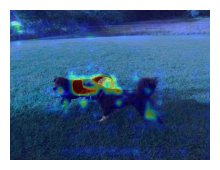

In [76]:
explanations = np.array([saliency_map])
X = np.array([image])
plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)